# 04 - Modelagem Preditiva
Autora: Fernanda Baptista de Siqueira  
Curso: MBA em Tecnologia para Negócios – AI, Data Science e Big Data  
Tema: Análise de Acidentes de Trânsito em Porto Alegre (2020–2024)  
Origem DataFrame: Equipe Armazém de Dados de Mobilidade - EAMOB/CIET  
https://dadosabertos.poa.br/dataset/acidentes-de-transito-acidentes (11/05/2025)  

### 1. Importa bibliotecas e funções. Carrega dados

In [10]:
from config import (
    pd, sns, plt, np, os,
    resumo_df, ajustar_tipos, 
    PATH_CLEAN, PATH_MODELOS
)

# Pré-processamento e modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Modelos
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Reprodutibilidade
RANDOM_STATE = 42

# Opções pandas
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


### 2. Carrega Dados. Trata Tipos

In [2]:
# Carregar dados limpos
df = pd.read_parquet(PATH_CLEAN + 'df_limpo_chuva.parquet')

# === Garantir existência do alvo UPS ===
if "ups" not in df.columns:
    raise ValueError("Coluna 'ups' (severidade Denatran) não encontrada na base.")

# === Converter datas e extrair features temporais ===
# A coluna de data pode ter nomes diferentes no seu pipeline; ajuste aqui se necessário
cand_datas = [c for c in df.columns if c.lower() in {"data", "data_hora", "datahora", "datetime"}]
if cand_datas:
    col_data = cand_datas[0]
    df[col_data] = pd.to_datetime(df[col_data], errors="coerce")
    # features de calendário (evitam modelos 'mirarem' diretamente em datas)
    df["ano"]  = df[col_data].dt.year
    df["mes"]  = df[col_data].dt.month
    df["dia"]  = df[col_data].dt.day
    if not df[col_data].dt.hour.isna().all():
        df["hora"] = df[col_data].dt.hour
else:
    col_data = None

# === Conversões de tipos problemáticos ===
# Muitos dados públicos usam Int32 com NA (pandas), o que dá erro em comparações/booleans no sklearn
int32_cols = df.select_dtypes(include="Int32").columns.tolist()
if int32_cols:
    df[int32_cols] = df[int32_cols].astype("float64")

# === Normalizar strings/categorias ===
# Objetivo: evitar KeyErrors por variações e manter categorias como 'category' (Hastie et al., 2009)
for c in df.select_dtypes(include=["object"]).columns:
    # strings padronizadas
    df[c] = df[c].astype(str).str.strip()

# Se você já tiver garantido categoria em outro caderno, isso é idempotente
for c in df.select_dtypes(include=["object"]).columns:
    # Converte para category para OHE eficiente e memória
    df[c] = df[c].astype("category")

# Exemplo de coluna de alta cardinalidade que pode inflar OHE (log1, logradouro)
# Caso queira manter, altere DROP_HIGH_CARD_COLS=False
DROP_HIGH_CARD_COLS = True
HIGH_CARD_THRESHOLD = 100  # ajuste conforme seu custo/infra
high_card_cats = [c for c in df.select_dtypes(include="category").columns
                  if df[c].nunique(dropna=True) > HIGH_CARD_THRESHOLD]

if DROP_HIGH_CARD_COLS:
    print("Removendo colunas categóricas de alta cardinalidade do OHE:", high_card_cats)
else:
    high_card_cats = []

# Alvo
y = df["ups"]

Removendo colunas categóricas de alta cardinalidade do OHE: []


### 3. Seleção de Features

In [3]:
# === Heurística de seleção ===
# Mantemos variáveis:
# - categóricas 'limpas' (regiao, tipo_acid, noite_dia, dia_sem, etc.)
# - numéricas comportamentais (contagens, totais de veículos, clima)
# - temporais derivadas (ano, mes, hora), não a data bruta
# - evitamos IDs/strings livres
# Ajuste a lista abaixo ao seu dicionário de dados.

# Sinalizações úteis do seu projeto
KNOWN_CAT = [c for c in ["regiao", "tipo_acid", "dia_sem", "noite_dia", "turno"]
             if c in df.columns]

# Colunas derivadas de data criadas acima
TIME_FEATS = [c for c in ["ano", "mes", "dia", "hora"] if c in df.columns]

# Veículos — você mencionou COL_VEIC em outro caderno; usamos uma inferência aqui
VEIC_PREFIX = {"auto","taxi","lotacao","onibus_urb","onibus_met","onibus_int",
               "caminhao","moto","carroca","bicicleta","outro","patinete"}
VEIC_COLS = [c for c in df.columns if c.split("_")[0] in VEIC_PREFIX]

# Variáveis de vitimização/contagem (se existirem, mas evitando 'ups' alvo)
COUNT_CANDS = [c for c in ["cont_vit","feridos","feridos_gr","fatais","queda_arr","predial1"]
               if c in df.columns and c != "ups"]

# Clima (chuva, temperatura etc.) — assuma nomes comuns; ajuste aos seus rótulos
WEATHER_CANDS = [c for c in df.columns
                 if any(k in c.lower() for k in ["chuva","precip","temp","vento","umid"])]

# Outras colunas categóricas já presentes
OTHER_CATS = [c for c in df.select_dtypes(include=["category"]).columns
              if c not in KNOWN_CAT and c not in high_card_cats]

# Montagem da lista final de features
FEATURES = sorted(set(KNOWN_CAT + TIME_FEATS + VEIC_COLS + COUNT_CANDS + WEATHER_CANDS + OTHER_CATS))

# Remover o alvo e colunas óbvias que não entram no modelo
DROP_EXACT = {"ups", "idacidente"}  # ajuste se existir 'idacidente'
FEATURES = [c for c in FEATURES if c not in DROP_EXACT]

print("Qtd features:", len(FEATURES))
print("Exemplo:", FEATURES[:30])

X = df[FEATURES].copy()

# Garantir categorias de interesse explícitas (ordem não importará no OHE, mas ajuda consistência)
if "regiao" in X.columns:
    X["regiao"] = X["regiao"].cat.set_categories(["NORTE","LESTE","CENTRO","SUL"], ordered=False)

# Remover high-cardinais se estiver ativo
for hc in high_card_cats:
    if hc in X.columns:
        X = X.drop(columns=[hc])

# Sanity check
display(X.dtypes.head(20))


Qtd features: 24
Exemplo: ['ano', 'auto', 'bicicleta', 'caminhao', 'carroca', 'chuva', 'cont_vit', 'dia', 'dia_sem', 'fatais', 'feridos', 'feridos_gr', 'hora', 'lotacao', 'mes', 'moto', 'noite_dia', 'outro', 'patinete', 'predial1', 'queda_arr', 'regiao', 'taxi', 'tipo_acid']


ano            float64
auto           float64
bicicleta      float64
caminhao       float64
carroca        float64
chuva          float32
cont_vit       float64
dia            float64
dia_sem       category
fatais         float64
feridos        float64
feridos_gr     float64
hora           float64
lotacao        float64
mes            float64
moto           float64
noite_dia     category
outro          float64
patinete       float64
predial1       float64
dtype: object

### 4. Treino, Validação e Teste (Split 70/15/15)

In [4]:
# Como o alvo UPS é um escore inteiro finito, vamos tratar como REGRESSÃO.
# Stratify não é usado em regressão; focamos em embaralhar e manter distribuição via amostragens aleatórias.

# 70% treino / 30% temporário
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

# Do temporário, metade vai para validação e metade para teste: 15% / 15%
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE
)

# Conversão final de Int32 -> float64 (se algo sobrou) para evitar "boolean value of NA is ambiguous"
for part in (X_train, X_valid, X_test):
    int32_cols = part.select_dtypes(include="Int32").columns
    if len(int32_cols) > 0:
        part[int32_cols] = part[int32_cols].astype("float64")

X_train.shape, X_valid.shape, X_test.shape


((48185, 24), (10326, 24), (10326, 24))

### 5. Pré-processadores (ColumnTransformer + Pipelines)

In [5]:
# Identificar colunas categóricas e numéricas
cat_cols = X_train.select_dtypes(include=["category","object"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler(with_mean=False))  # com sparse safety
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    n_jobs=None
)

print(f"{len(num_cols)} numéricas | {len(cat_cols)} categóricas")


20 numéricas | 4 categóricas


### 6. Modelos Candidatos

In [6]:
modelos = {
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=RANDOM_STATE
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE)
}

def _rmse(y_true, y_pred):
    # Compatível com qualquer versão do sklearn
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def avaliar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = _rmse(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

resultados = {}

for nome, estimador in modelos.items():
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("model", estimador)
    ])
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_valid)
    met = avaliar(y_valid, y_hat)
    resultados[nome] = met
    print(f"{nome}: {met}")

melhor_nome = min(resultados, key=lambda k: resultados[k]["RMSE"])
melhor_score = resultados[melhor_nome]
melhor_nome, melhor_score

Ridge: {'MAE': 0.01037452426194893, 'RMSE': np.float64(0.28304952082612117), 'R2': 0.981932557146923}
RandomForest: {'MAE': 0.0, 'RMSE': np.float64(0.0), 'R2': 1.0}
GradientBoosting: {'MAE': 5.196117197392969e-05, 'RMSE': np.float64(5.593610355698161e-05), 'R2': 0.9999999992944038}


('RandomForest', {'MAE': 0.0, 'RMSE': np.float64(0.0), 'R2': 1.0})

### 7. Re-treino em treino+validação e Avaliação Final no Teste

In [7]:

from copy import deepcopy

# Recuperar o melhor estimador
best_est = deepcopy(modelos[melhor_nome])

# Re-treinar em Treino+Validação
X_trval = pd.concat([X_train, X_valid], axis=0)
y_trval = pd.concat([y_train, y_valid], axis=0)

best_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", best_est)
])

best_pipe.fit(X_trval, y_trval)

# Avaliação final
y_hat_test = best_pipe.predict(X_test)
final_metrics = avaliar(y_test, y_hat_test)  # usa a função compatível com _rmse
print("Melhor modelo:", melhor_nome)
print("Métricas em TESTE:", final_metrics)


Melhor modelo: RandomForest
Métricas em TESTE: {'MAE': 0.0, 'RMSE': np.float64(0.0), 'R2': 1.0}


### 8. Interpretação e Checagens de Estabilidade

In [8]:
# Erro por quantis do y (útil porque UPS é discreta)
bins = pd.qcut(y_test, q=4, duplicates='drop')
df_err = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_hat_test,
    "bin": bins
})
df_err["abs_err"] = (df_err["y_true"] - df_err["y_pred"]).abs()
print("\nMAE por faixa de severidade (quartis do UPS):")
print(df_err.groupby("bin")["abs_err"].mean().to_frame("MAE_bin"))

# Importâncias de features (para árvores)
if melhor_nome in {"RandomForest", "GradientBoosting"}:
    ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    feat_names = np.r_[num_cols, cat_feature_names]
    importancias = best_pipe.named_steps["model"].feature_importances_
    imp = (pd.DataFrame({"feature": feat_names, "importance": importancias})
             .sort_values("importance", ascending=False)
             .head(30))
    print("\nTop 30 features mais importantes:")
    print(imp)



MAE por faixa de severidade (quartis do UPS):
              MAE_bin
bin                  
(0.999, 5.0]     0.00
(5.0, 13.0]      0.00

Top 30 features mais importantes:
            feature  importance
6          cont_vit        0.92
8            fatais        0.08
0               ano        0.00
2         bicicleta        0.00
1              auto        0.00
4           carroca        0.00
3          caminhao        0.00
5             chuva        0.00
7               dia        0.00
9           feridos        0.00
10       feridos_gr        0.00
11             hora        0.00
12          lotacao        0.00
13              mes        0.00
14             moto        0.00
15            outro        0.00
16         patinete        0.00
17         predial1        0.00
18        queda_arr        0.00
19             taxi        0.00
20  dia_sem_Domingo        0.00
21   dia_sem_Quarta        0.00
22   dia_sem_Quinta        0.00
23  dia_sem_Segunda        0.00
24    dia_sem_Sexta        0.0

### 9. Conclusões e Persistência do Modelo

In [12]:
from joblib import dump

os.makedirs(PATH_MODELOS, exist_ok=True)
caminho_modelo = PATH_MODELOS + f"modelo_ups_{melhor_nome.lower()}.joblib"
dump(best_pipe, caminho_modelo)

print("Modelo salvo em:", caminho_modelo)

Modelo salvo em: ../apendices/modelos/modelo_ups_randomforest.joblib


## Extras:
#### 10. Interpretação de Modelos com SHAP

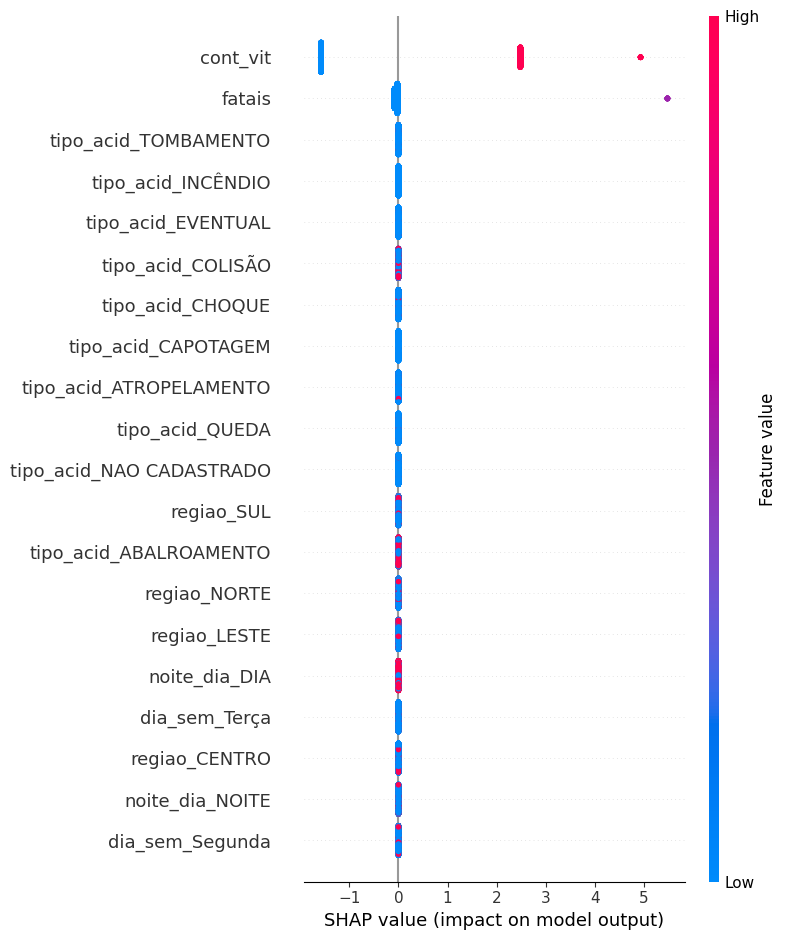

In [13]:
# === Célula 10 — Interpretabilidade com SHAP (corrigida) ===
import shap
import numpy as np

AMOSTRA = min(2000, len(X_test))
X_test_sample = X_test.sample(AMOSTRA, random_state=RANDOM_STATE)

# Transformar no espaço numérico já pré-processado
X_test_transf = best_pipe.named_steps["prep"].transform(X_test_sample)

# Recuperar nomes das features após o ColumnTransformer
ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feat_names = np.r_[num_cols, cat_feature_names]

# Ajustar explainer para modelos de árvore
if melhor_nome in {"RandomForest", "GradientBoosting"}:
    explainer = shap.TreeExplainer(best_pipe.named_steps["model"])
    shap_values = explainer.shap_values(X_test_transf)

    # Gráfico global (importâncias SHAP)
    shap.summary_plot(
        shap_values,
        X_test_transf,
        feature_names=feat_names,
        show=True
    )

    # Explicação local (primeira instância da amostra)
    shap.initjs()
    shap.force_plot(
        explainer.expected_value,
        shap_values[0, :],
        feature_names=feat_names
    )
else:
    print("SHAP TreeExplainer é indicado para modelos baseados em árvores. "
          "Seu melhor modelo foi:", melhor_nome)


### 11. Prepara série temporal mensal (alvo + exógenas)

In [23]:
# Preparar série temporal mensal (UPS e clima)

# Detecta coluna de data já carregada anteriormente (mesma heurística das células iniciais)
cand_datas = [c for c in df.columns if c.lower() in {"data","data_hora","datahora","datetime"}]
if not cand_datas:
    raise ValueError("Não encontrei coluna de data. Ajuste a lista cand_datas.")
col_data = cand_datas[0]
df[col_data] = pd.to_datetime(df[col_data], errors="coerce")
df_ts = df.set_index(col_data).sort_index()

# ---- Escolha do alvo temporal ----
# Opção A (padrão): severidade mensal = soma de UPS no mês (carga de severidade)
# Opção B: contagem de acidentes mensais = df.resample('M').size()
TARGET_MODE = "sum_ups"  # mude para "count" se quiser contar acidentes

if TARGET_MODE == "sum_ups":
    y_mensal = df_ts.resample("M")["ups"].sum().rename("y")
elif TARGET_MODE == "count":
    y_mensal = df_ts.resample("M").size().rename("y")
else:
    raise ValueError("TARGET_MODE inválido. Use 'sum_ups' ou 'count'.")

# ---- Exógenas de clima (chuva/precip = soma mensal; outras (temp, umid, vento) = média mensal) ----
weather_cols = [c for c in df_ts.columns if any(k in c.lower() for k in ["chuva","precip","temp","umid","vento"])]
exog = None
if weather_cols:
    clima = df_ts[weather_cols].copy()
    # separa precipitação/chuva das demais
    chuva_cols = [c for c in weather_cols if any(k in c.lower() for k in ["chuva","precip"])]
    outras_cols = [c for c in weather_cols if c not in chuva_cols]

    partes = []
    if chuva_cols:
        partes.append(clima[chuva_cols].resample("M").sum(min_count=1))
    if outras_cols:
        partes.append(clima[outras_cols].resample("M").mean())

    if partes:
        exog = pd.concat(partes, axis=1)

# Alinha alvo e exógenas
if exog is not None:
    df_m = pd.concat([y_mensal, exog], axis=1)
else:
    df_m = y_mensal.to_frame()

# Recorta período útil (se sua base começar antes/depender do recorte, ajuste aqui)
df_m = df_m.loc["2020-01-01":]  # garante janela 2020+
df_m = df_m.asfreq("M")  # frequência mensal explícita

print("Período:", df_m.index.min().date(), "→", df_m.index.max().date())
print("Colunas:", list(df_m.columns))
df_m.tail()


Período: 2020-01-31 → 2025-03-31
Colunas: ['y', 'chuva']


,y,chuva
data,,
2024-11-30,"3,693.00",231.80
2024-12-31,"3,716.00",275.30
2025-01-31,"3,133.00",212.10
2025-02-28,"3,207.00",164.50
2025-03-31,"1,823.00",63.20


### 12. Split temporal e padronização

In [15]:
# === Célula 12 — Split temporal (train até 2024-12; teste 2025-01..2025-05) ===
from sklearn.preprocessing import StandardScaler

train_end = "2024-12-31"
test_end  = "2025-05-31"

treino = df_m.loc[:train_end].copy()
teste  = df_m.loc["2025-01-01":test_end].copy()

y_train = treino["y"]
y_test  = teste["y"]

X_train = treino.drop(columns=["y"]) if "y" in treino.columns else None
X_test  = teste.drop(columns=["y"])  if "y" in teste.columns  else None

scaler = None
if X_train is not None and X_train.shape[1] > 0:
    # Padroniza exógenas para estabilidade numérica
    scaler = StandardScaler()
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        index=X_train.index, columns=X_train.columns
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test),
        index=X_test.index, columns=X_test.columns
    )

print("Tamanhos — treino:", len(y_train), "| teste:", len(y_test))
X_train.head() if X_train is not None else print("Sem exógenas.")


Tamanhos — treino: 60 | teste: 3


,chuva
data,
2020-01-31,-0.11
2020-02-29,-0.95
2020-03-31,-0.93
2020-04-30,-1.40
2020-05-31,-0.86


### 13. Ajuste SARIMAX (com auto_arima, se disponível) e avaliação

In [21]:
# === Célula 13 — Ajuste SARIMAX e avaliação ===
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float)
    yp = np.asarray(y_pred, dtype=float)
    eps = 1e-9
    return np.mean(np.abs((yt - yp) / np.maximum(np.abs(yt), eps))) * 100.0

# Tenta auto_arima se pmdarima estiver instalado
order = (1,0,1)
seasonal_order = (1,0,1,12)

use_auto = False
try:
    import pmdarima as pm
    use_auto = True
except Exception:
    use_auto = False

if use_auto:
    # auto_arima em treino, com exógenas se existirem
    auto_model = pm.auto_arima(
        y_train,
        X=X_train if X_train is not None and X_train.shape[1] > 0 else None,
        seasonal=True, m=12,
        stepwise=True, trace=False,
        error_action="ignore", suppress_warnings=True,
        max_p=3, max_q=3, max_P=2, max_Q=2,  # limites razoáveis
        max_order=10
    )
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order
    print("auto_arima escolheu:", order, seasonal_order)

# Ajusta SARIMAX final
model = SARIMAX(
    endog=y_train,
    exog=X_train if X_train is not None and X_train.shape[1] > 0 else None,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# Forecast no horizonte do teste
pred = res.get_forecast(steps=len(y_test),
                        exog=X_test if X_test is not None and X_test.shape[1] > 0 else None)
y_hat = pred.predicted_mean
conf_int = pred.conf_int(alpha=0.05)

mae = mean_absolute_error(y_test, y_hat)
rmse = _rmse(y_test, y_hat)
mp = mape(y_test, y_hat)

print({"MAE": mae, "RMSE": rmse, "MAPE_%": mp})
try:
    print(res.summary())
except Exception:
    pass


{'MAE': 723.8860469720244, 'RMSE': np.float64(1162.937152366389), 'MAPE_%': np.float64(38.44266231096384)}
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -350.199
Date:                            Mon, 29 Sep 2025   AIC                            712.398
Time:                                    01:57:33   BIC                            723.369
Sample:                                01-31-2020   HQIC                           716.508
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
chuva  

### 14. Gráficos (ajuste vs real, resíduos e intervalo de confiança)

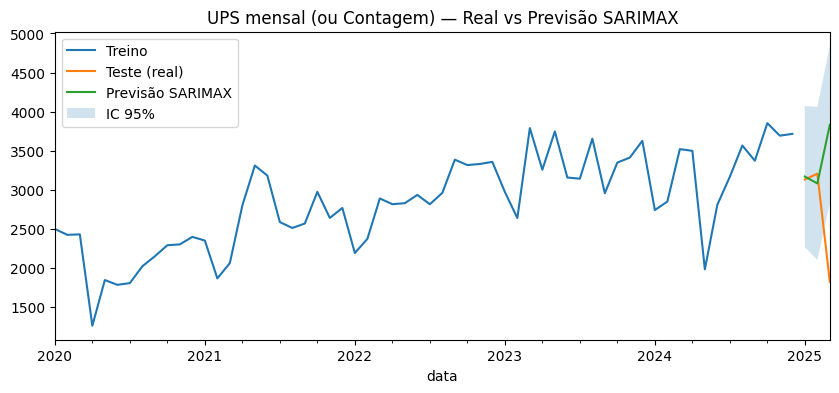

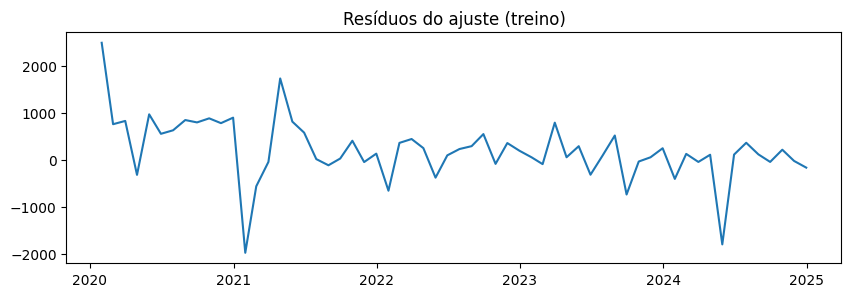

In [22]:
# === Célula 14 — Gráficos (corrigida e robusta) ===
import matplotlib.pyplot as plt

# Constrói previsão alinhada ao índice do teste
# força o tamanho a bater com y_test
y_hat_arr = np.asarray(y_hat).ravel()[:len(y_test)]
y_hat_series = pd.Series(y_hat_arr, index=y_test.index)

fig, ax = plt.subplots(figsize=(10,4))
y_train.plot(ax=ax, label="Treino")
y_test.plot(ax=ax, label="Teste (real)")
y_hat_series.plot(ax=ax, label="Previsão SARIMAX")

# Intervalo de confiança (mesmo alinhamento)
try:
    conf_int_df = pd.DataFrame(conf_int.values[:len(y_test)],
                               index=y_test.index,
                               columns=conf_int.columns)
    ax.fill_between(conf_int_df.index,
                    conf_int_df.iloc[:,0],
                    conf_int_df.iloc[:,1],
                    alpha=0.2, label="IC 95%")
except Exception as e:
    print("Aviso: não foi possível plotar IC:", e)

ax.set_title("UPS mensal (ou Contagem) — Real vs Previsão SARIMAX")
ax.legend()
plt.show()

# Resíduos do treino
resid = res.resid
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(resid)
ax.set_title("Resíduos do ajuste (treino)")
plt.show()


---------

## Referenciais Teóricos

- Breiman (2001): *Two Cultures* → interpretação vs predição.
- Bishop (2006), Hastie, Tibshirani & Friedman (2009), Murphy (2012): fundamentos estatísticos e probabilísticos.
- Géron (2023), Müller & Guido (2016), Faceli et al. (2021): boas práticas em pipelines e scikit-learn.
- Zabala (2019, 2021): aplicações de modelagem preditiva.
- Pearl et al. (2016): inferência causal.
- Vilone & Longo (2020): interpretabilidade.
- Bao et al. (2020): incerteza espaço-temporal.
- Chen et al. (2025): ensembles avançados.